In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Posterior Estimation

We're now going to develop a posterior function for use in Bayesian inference of source properties.  The posterior density function describes the distribution of probability (density) for all of our model parameters after observations:

$$
p(\vec{\theta}|\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}) = \frac{p(\vec{\theta})p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}|\vec{\theta})}{p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\})},
$$

where $\vec{\theta}$ contains all of the parameters we don't know, and $\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}$ are our data, in this case the strain measurements across $\mathrm{N}_f$ discrete frequency bins.

$p(\vec{\theta})$ is the *prior*, describing our knowledge of the parameters before recording any data, e.g., we expect compact binaries' orientations to be isotropically distributed.  $p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}|\vec{\theta})$ is the *likelihood*, which is the probability of observing the data that we've observed *if* all of the unknown parameters were to have values $\vec{\theta}$.  Finally, $p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\})$ is the *evidence*, which for simple parameter estimation is a normalization that we can ignore, but becomes useful for model comparisons. 

To be successful in our Bayesian endeavor, we need forward models to describe (probabilistically) our observed data, i.e., signal and noise processes.  From now on we'll be making strong assumptions about the content of the data, specifically that the data consist of stationary, Gaussian noise with a known power spectral density, and a compact binary signal as described by our `SEOBNRv4` model.

#### Getting the software environment setup

PyCBC is installable through pip, but also relies on portions of the [LALSuite]() c-library. A bundled version of this suitable for use with PyCBC is also available on Mac / Linux through pip. These can be installed as follows within the notebook.

In [3]:
# -- For Google Colab
#! pip install -q "lalsuite==6.67" "pycbc==1.15.3"

## Data

As a concrete example we're going to work with the data containing **GW150914**.  Since we know *a priori* that there isn't any signal content about 1 kHz, we'll downsample the data to 2048 Hz for faster processing.  We'll also focus on the Hanford data for now.

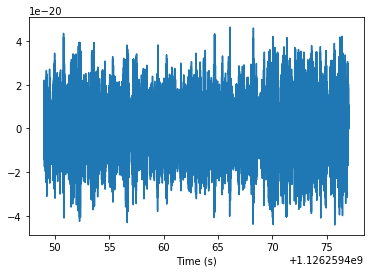

In [4]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)');

# Likelihood

## Noise model

We know the time around **GW150914** to be well-behaved, and by that we mean stationary and Gaussian.  That means we can completely describe the (statistical) properties of the noise by the power spectral density, which we'll estimate using off-source data following the procedure in the [PyCBC matched filtering exercise](https://git.ligo.org/jonah-kanner/odw-2018/blob/master/pycbc/3_WaveformMatchedFilter.ipynb).

In [5]:
f_lower = 20.
f_upper = 1024.

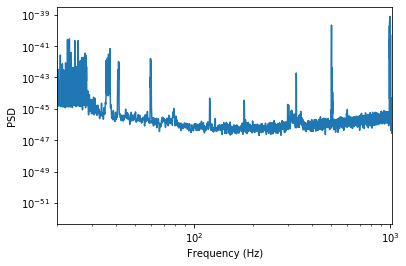

In [6]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)

psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

plt.loglog(fs, psd)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD");

That's it.  We're going to assume that our noise is exactly described by the PSD estimated above.  In other words, we're employing a 0-parameter noise model.

For production analyses we make use of the [BayesLine](https://arxiv.org/abs/1410.3852) algorithm, which employs a parametric model for the PSD itself and allows us to work with only on-source data.

## Signal model

We're going to use the `SEOBNRv4` approximant, which describes the inspiral, merger, and ringdown phases of a binary black hole merger using a combination of analytical approximations and fits to numerical relativity simulations.

In [7]:
from pycbc import filter
from pycbc.types import Array

from pycbc.waveform import get_td_waveform

For simplicity we'll assume an equal-mass binary, which we already know is consistent with (but not demanded by) the data.

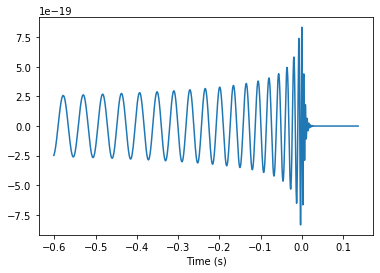

In [8]:
m = 36. # Solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

Notice that `get_td_waveform()` returns two polarizations of strain.  For now we'll just make use of the plus polarization.

For visualization (and as a proxy for what the analysis "sees" under the hood), it will be useful to look at the whitened data, where the data have been filtered to produce a flat PSD.  (Again, see the [PyCBC matched filtering exercise](https://git.ligo.org/jonah-kanner/odw-2018/blob/master/pycbc/3_WaveformMatchedFilter.ipynb) for more details).

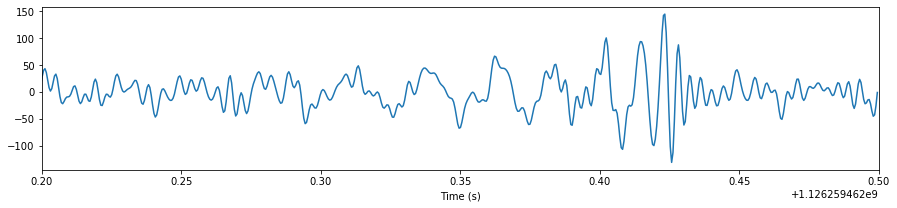

In [9]:
white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data)
plt.xlim(merger.time-.2, merger.time+.1)
plt.xlabel('Time (s)');

Now we'll make a light-weight wrapper for `get_td_waveform()` that will take parameter vector $\vec{\theta}$ and generate a waveform for us with the same sampling rate and time window as our data.  For now we'll plan on varying component mass (again, assuming an equal-mass binary), distance, merger time, and merger phase.

Since we're only working with one detector now, we're only sensitive to one polarization, and we can't tell where on the antenna pattern our source lies.  This means we have no sensitivity to inclination, as it's entirely degenerate with distance, and that what we'll be measuring here isn't actually distance, but the distance the binary would need to be at if optimally oriented directly over-head of the detector.

In [10]:
def gen_template(theta,
                 delta_t=strain.delta_t,
                 duration=strain.duration,
                 start_time=strain.start_time,
                 f_lower=f_lower):
    
    m, distance, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m,
                             mass2=m,
                             distance=distance,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain.start_time)
    hp.start_time = strain.start_time

    return hp

## Single-detector Likelihood

With that, we're now able to define our likelihood function, which is the likelihood of observing the data we have, given particular values for all of the parameters in our model.

The probabilistic component of the data comes enstirely from the noise.  So given a guess for the source parameters $\vec{\theta}$, our likelihood is the statistical measure of the probability of the residuals (data with the model signal subtracted) having come from the noise process described by the PSD:

$$
p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}|\vec{\theta}) = \exp \left(-\frac{1}{2}\langle h(\vec{\theta})-d|h(\vec{\theta})-d\rangle\right),
$$

where $\langle\rangle$ denotes an inner product:

$$
\langle a|b\rangle = 4 \Re \int_0^\infty \frac{a(f)b(f)}{S_n(f)}df,
$$

where $S_n(f)$ is the PSD of the detector.  Notice that the noise-only hypothesis reduces to:

$$
p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\} | n) = \exp \left( -\frac{1}{2}\sum_i^{\mathrm{N}_f}\langle d_i|d_i\rangle\right),
$$

We can divide our likelihood by this to obtain the likelihood ratio, the ratio of the likelihood of a signal described by $\vec{\theta}$ to the likelihood of noise only.  Since we aren't worried about normailzation of the likelihood anyways we'll work in the likelihood ratio, since it has the nice feature that when maximized it should be equal to $\mathrm{SNR}^2/2$.

Since we'll be working in the frequency domain, we'll FFT the data once ahead of time.

In [11]:
# FFT the data once, ahead of time
df = strain.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_lower, f_upper=f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_lower)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    logl = -0.5*(hh - 2.0*dh)

    return logl

Since we'll be doing it a lot, let's define some whitening and plotting functions to save time later on.

In [12]:
def whiten_trim_template(template, psd=psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_template

def plot_whitened_strains(strain, template):
    white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(merger.time-.2, merger.time+.1)
    plt.legend()

Now let's pick some particular values for the model parameters that we know to be in the right ballpark and generate a model signal.  We'll then whiten it and compare it to the data, and calculate the likelihood.

-483.20305876011713


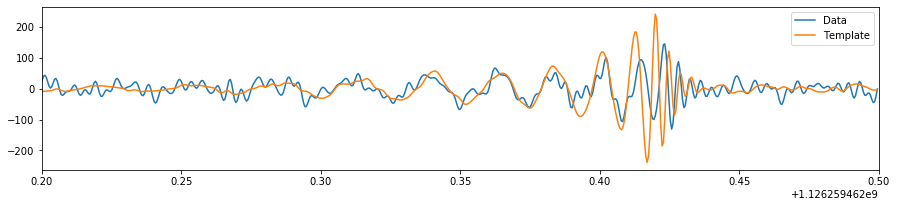

In [13]:
# m, distance, time, phase
theta0 = [36., 462., float(merger.time)+.02, 0.]

template0 = gen_template(theta0)
plot_whitened_strains(strain, template0)

print(loglikelihood(theta0))

Now let's maximize the likelihood to find the best-fit signal.  We'll use the `minimize()` function provided by scipy using the Powell method, since it's pretty good at dealing with non-smooth functions.  We'll also define a callback function to print likelihood values and plot the model as it works.

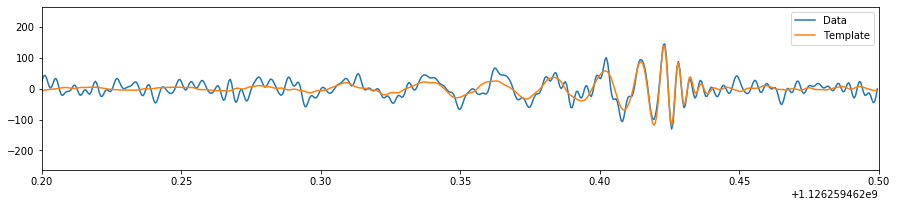

Steps	log(likelihood)
7	202.816


In [14]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim_template(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label="Data")
line, = plt.plot(whitened_template.sample_times, whitened_template, label="Template")

plt.xlim(merger.time-.2, merger.time+.1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

We've now got our best-fit waveform, and it matches the data fairly well (by eye at least):

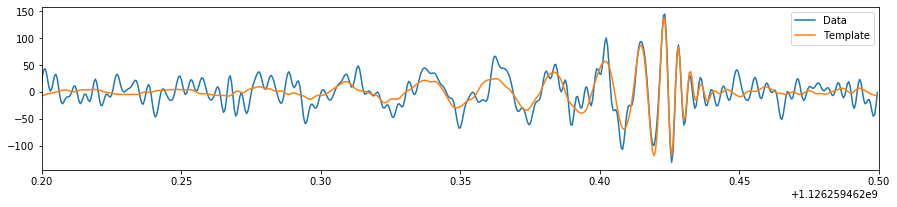

In [15]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

plot_whitened_strains(strain, best_fit_template)

Now let's subtract it from the data and see how consistent the residuals are with noise.

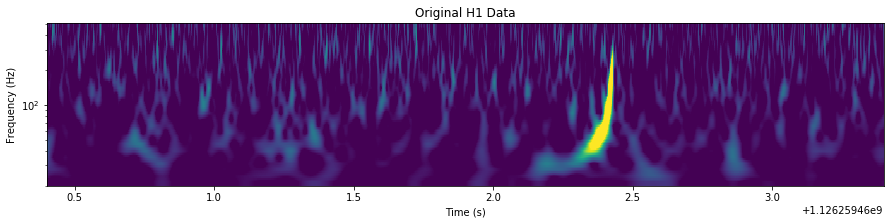

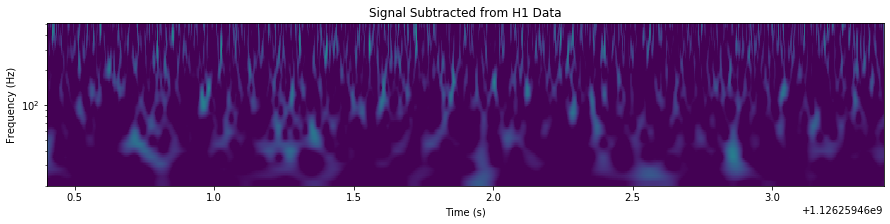

In [16]:
subtracted = strain - best_fit_template

# Plot the original data and the subtracted signal data

for data, title in [(strain, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                          logfsteps=100,
                                          qrange=(8, 8),
                                          frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - 2, merger.time + 1)

## Network Likelihood

So far we've only worked with one detector, and our inference abilities have been restricted by this.

To construct a likelihood function for the GW detector network (the two LIGO instruments in this case), we will make the very reasonable assumption that noise is independent between detectors.  This means that our network likelihood fuction is just the product of single-detector likelihood functions.

$$
\log \mathcal{L}_\mathrm{net} = \sum_{j \in \{\mathrm{H1}, \mathrm{L1}\}} \log \mathcal{L}_\mathrm{j}
$$

Let's now get Livingston's data for **GW150914** as well.

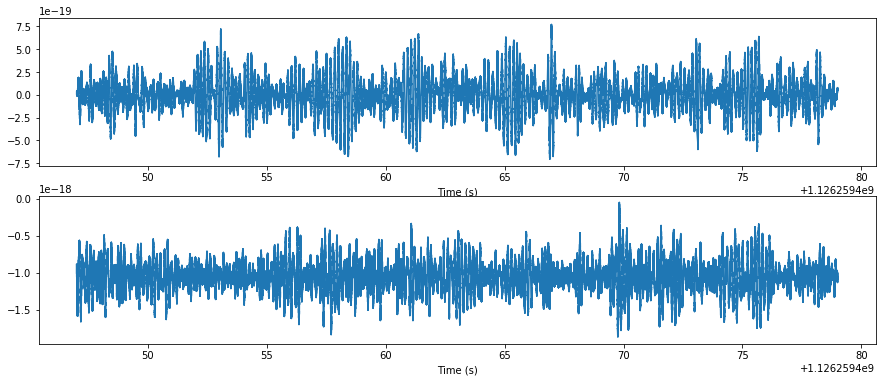

In [17]:
from pycbc.detector import Detector

dets = ['H1', 'L1']

# Get the data from the Hanford detector
strains = dict([(det, merger.strain(det)) for det in dets])

# Remove the low frequency content and downsample the data to 2048Hz
for det, strain in strains.items():
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
for ax, det in zip(axs, dets):
    ax.plot(strains[det].sample_times, strains[det])
    ax.set_xlabel('Time (s)')

We now need to calculate a separate PSD for each detector.

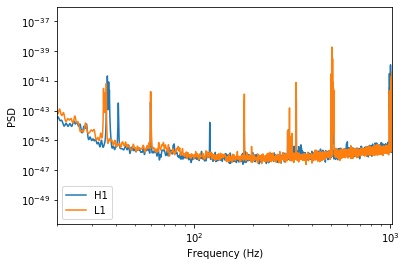

In [18]:
psds = {}

for det in dets:
    psd = strains[det].psd(4)
    psd = interpolate(psd, strains[det].delta_f)

    psds[det] = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

for det in dets:
    plt.loglog(fs, psds[det], label=det)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend(loc='lower left');

Let's take a look at the whitened data.

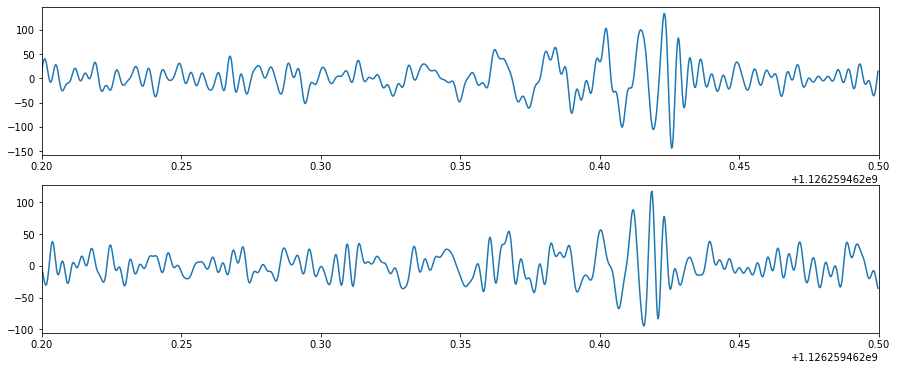

In [19]:
white_net_data = {}
for det in dets:
    white_net_data[det] = (strains[det].to_frequencyseries() / psds[det]**0.5).to_timeseries()
    white_net_data[det] = white_net_data[det].highpass_fir(30., 512).lowpass_fir(300, 512)
    white_net_data[det] = white_net_data[det].time_slice(merger.time-.2, merger.time+.1)
    
fig, axs = plt.subplots(2, 1, figsize=[15, 6])

for ax, det in zip(axs, dets):
    ax.plot(white_net_data[det].sample_times, white_net_data[det])

    ax.set_xlim(merger.time-.2, merger.time+.1)

With two detectors we are potentially sensitive to more than a single polarization of gravitational waves.  We also have to account for the delay in the time of arrival of the signal based on where in the sky the source may be located.  This expands our parameters to be component mass (assuming an equal mass binary), right ascension, declination, luminosity distance, inclination, merger time, merger phase, and polarization angle.

For a give set of parameters $\vec{\theta}$ we'll now have to generate the plus and cross polarizations of the GW emission (taking into account the inclination of the binary, and scaling to the proper distance), then combine these with each detector's antenna pattern (which depend on the location of the binary relative to the detector's orientation) to determine the detector response.  Finally, we have to shift the time of arrival of the signal to be consistent with the delay time expected based on the RA and dec of the binary.

In short, you can think of the process as generating the geocenter waveform then projecting it across the network.

In [20]:
def net_gen_template(theta, dets=['H1', 'L1'],
                     delta_t=strains['H1'].delta_t,
                     duration=strains['H1'].duration,
                     start_time=strains['H1'].start_time,
                     f_lower=f_lower):
    m, ra, dec, distance, inclination, time, coa_phase, polarization = theta

    # generate geocenter waveform
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m,
                             mass2=m,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=coa_phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    hp.resize(len(strains['H1']))
    hc.resize(len(strains['H1']))
    hp = hp.cyclic_time_shift(hp.start_time + time - start_time)
    hc = hc.cyclic_time_shift(hc.start_time + time - start_time)

    # project geocenter waveform onto detectors
    h = {}
    for det in dets:
        ifo = Detector(det)
        fp, fc = ifo.antenna_pattern(ra, dec, polarization, time)
        ifo_h = fp*hp.copy() + fc*hc.copy()
        dt = ifo.time_delay_from_earth_center(ra, dec, time)
        h[det] = ifo_h.cyclic_time_shift(dt)
        h[det].start_time = start_time


    return h

With the network waveform generator now defined, we can define our likelihood function, which is equivalent to the product of single-detector likelihood functions.

In [21]:
# FFT the data once, ahead of time
dfs = dict([(det, strain.to_frequencyseries()) for det, strain in strains.items()])

def net_loglikelihood(theta, dfs=dfs, psds=psds, f_lower=f_lower, f_upper=f_upper):
    dets = list(dfs.keys())
    logl = 0
    
    # assume identical sampling rates, sampling times, etc.
    df = dfs[dets[0]]
    delta_t = df.delta_t
    duration = df.duration
    N = int(duration/delta_t)
    start_time = df.start_time
    
    # Return p=0 if waveform generation fails
    try:
        hts = net_gen_template(theta, dets=dets, delta_t=delta_t, duration=duration, start_time=start_time, f_lower=f_lower)
    except RuntimeError:
        return -np.inf
    
    # Sum over single-detector likelihoods
    for det, df in dfs.items():
        psd = psds[det]
        hf = hts[det].to_frequencyseries()

        kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

        hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        logl += -0.5*(hh - 2.0*dh)

    return logl

Again, we can pick some values for the parameters that are in the right ballpark and compare with the data.

In [22]:
# m, ra, dec, distance, inclination, time, coa_phase, polarization
theta0 = [36., 2.2, -1.2, 400., np.pi, float(merger.time)+.008, 0., 0.]

net_loglikelihood(theta0)

-9.747167735737378

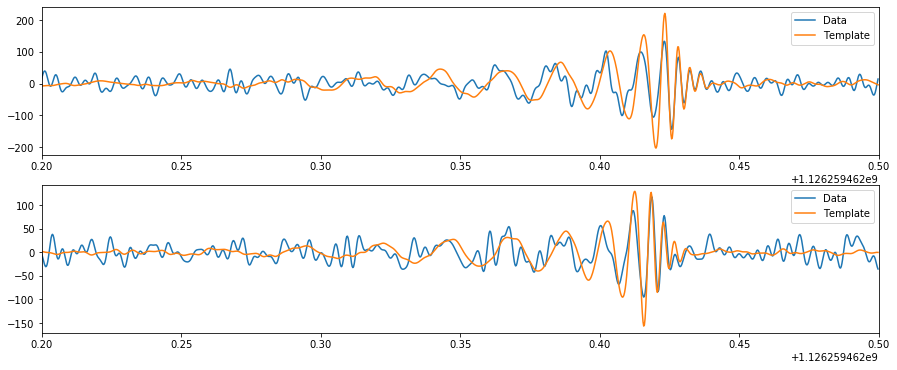

In [23]:
hts = net_gen_template(theta0)
fig, axs = plt.subplots(2, 1, figsize=[15, 6])

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

Now let's maximize the network likelihood, and see how well our best-fit model does at removing the signal.

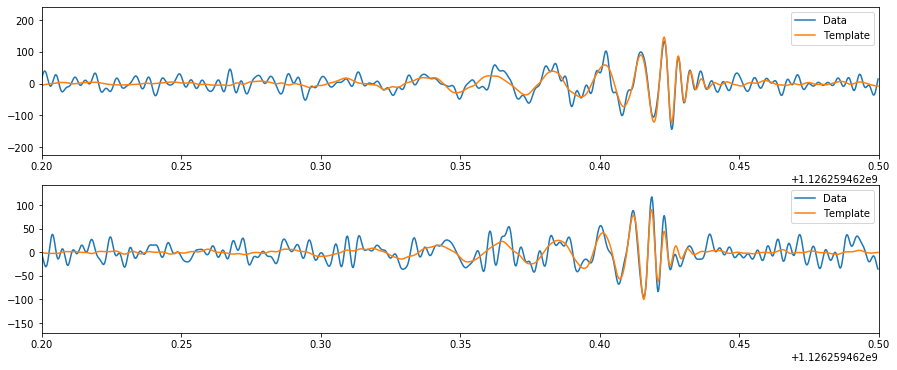

Steps	log(likelihood)
7	292.952


In [24]:
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim_template(templates[det], psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, net_loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -net_loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

In [25]:
best_fit = res.x
best_fit_templates = net_gen_template(best_fit, start_time=strains["H1"].start_time)

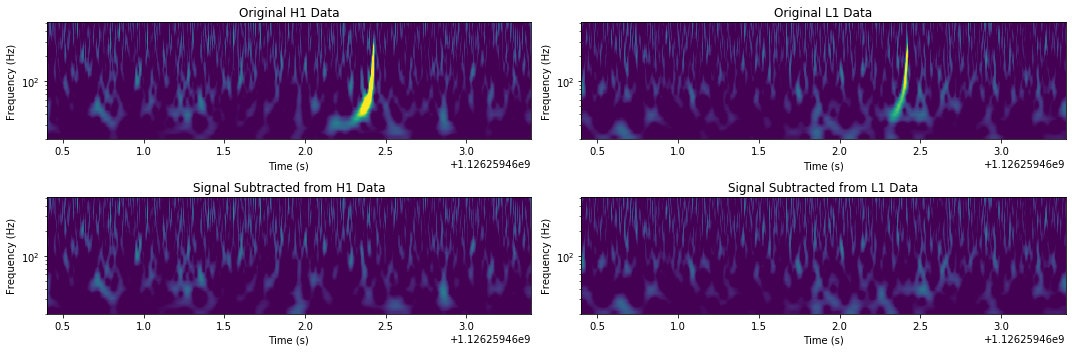

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

for i, det in enumerate(dets):
    subtracted = strains[det] - best_fit_templates[det]

    # Plot the original data and the subtracted signal data
    for ax, data, title in [(axs[0][i], strains[det], 'Original {} Data'.format(det)),
                        (axs[1][i], subtracted, 'Signal Subtracted from {} Data'.format(det))]:

        t, f, p = data.whiten(4, 4).qtransform(.001,
                                              logfsteps=100,
                                              qrange=(8, 8),
                                              frange=(20, 512))
        ax.set_title(title)
        ax.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlim(merger.time - 2, merger.time + 1)
plt.tight_layout()

# Prior

So far we've focused on the likelihood, but equally important to Bayesian inference is our prior, the knowledge of the distribution of model parameters that we have *before* taking any measuments.

If we were to sample the likelihood function defined above without specifying any priors, we are implicitly adopting uniform priors for the parameters of the model.  In other words, if we were to sample the same likelihood in a different parameterization, we would implicitly be using a *different* prior for our analysis.

While uniform priors for some parameters (e.g., merger time, merger phase, etc.) are justified, the fact that we expect sources to be distributed uniformly in the local universe (to 1st order) needs to be included in our prior, i.e.,

$$
p(\alpha, \delta) \propto \cos(\delta),
$$

where $\delta \in [-\pi/2, \pi/2]$ is the declination of the source, and

$$
p(D, \iota) \propto D^2\sin(\iota)
$$

where $D$ is the luminosity distance to the source, and $\iota$ is the inclination angle of the binary.

In [27]:
def logprior(theta):
    logp = 0
    
    m, ra, dec, distance, inclination, time, coa_phase, polarization = theta
    
    for angle in [ra, coa_phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf
    
    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    return logp

# Posterior

With network likelihood and prior defined we can now take their product to get the posterior.

In [28]:
def logposterior(theta, **kwargs):
    logpost = logprior(theta)
    if np.isfinite(logpost):
        logpost += net_loglikelihood(theta)
    return logpost

In [29]:
logposterior(theta0)

-35.41807093737043

We can now maximize the posterior to determine the *maximum a posteriori* (MAP) parameters.  

Where the maximum likelihood point was the "best fit" in the sense that it found the parameters that produced a model most consistent with the data, the MAP is more of a "best guess" in that it balances fitting the data with being consistent with prior expectations for source parameters.

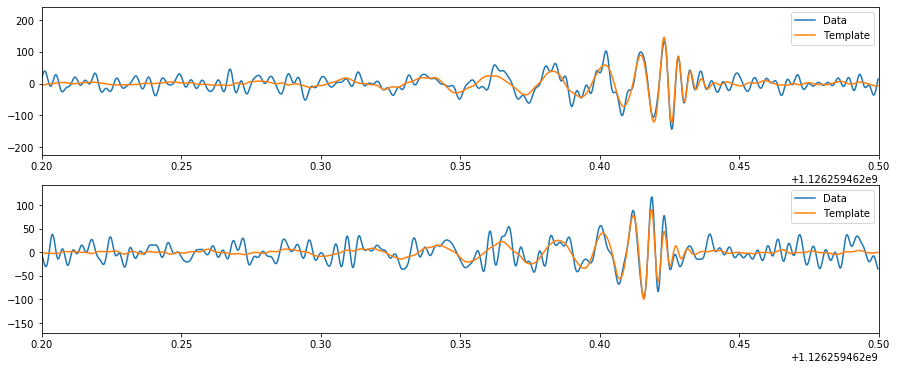

Steps	log(posterior)
11	303.350


In [30]:
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim_template(templates[det], psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -logposterior(theta), theta0, callback=callback, method='powell')
plt.close()

In [31]:
best_guess = res.x
print(best_guess)

[ 3.70198433e+01  2.22123900e+00 -1.22989217e+00  5.31918189e+02
  2.53078901e+00  1.12625946e+09  2.82401517e-01  3.36792528e-03]


# Posterior sampling

So far we've been generating point estimates for the source parameters, but the whole point of this endeavor was to quantify uncertainties.  With our posterior function defined we can now plug into into a Markov chain Monte Carlo sampler in order to draw samples from this probability density function.

With a posterior density function defined, you can now use off-the-shelf samplers like [emcee](http://dfm.io/emcee/current/) or [kombine](http://pages.uoregon.edu/bfarr/kombine/) to draw samples from the posterior probability density function.